# Policy Gradient with Value Function Baseline

Lecture 15 | CMU ANLP Fall 2025 | Instructor: Sean Welleck

This notebook demonstrates reinforcement learning using the REINFORCE algorithm with a value function baseline on the CartPole environment.


In [1]:
# !pip install "gymnasium[classic-control]"
import gymnasium as gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from IPython.display import HTML
%matplotlib inline

### 1. Environment

In [2]:
# Create the CartPole environment
env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset(seed=42)
torch.manual_seed(42)

### 2. Policy Network and Value Function

In [4]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.affine1(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

class VF(nn.Module):
    def __init__(self):
        super(VF, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.affine2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.affine1(x)
        x = F.relu(x)
        v = self.affine2(x)
        return v


### 3. Training

In [5]:
policy = Policy()
vf = VF()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
optimizer2 = optim.Adam(vf.parameters(), lr=1e-2)

running_reward = 10
num_episodes = 10000
max_steps_per_episode = 10000
log_interval = 10
running_reward = 10
discount_gamma = 0.99
EPS = np.finfo(np.float32).eps.item()

reward_history = []

for i_episode in range(num_episodes):
    state, _ = env.reset()
    ep_reward = 0

    # 1. Collect an episode trajectory
    log_probs, rewards, values = [], [], []
    for t in range(1, max_steps_per_episode):
        state = torch.tensor(state).unsqueeze(0)
        probs = policy(state)

        v = vf(state)
        p = Categorical(probs)
        action = p.sample()
        log_prob = p.log_prob(action)

        state, reward, terminated, truncated, _ = env.step(action.item())

        log_probs.append(log_prob)
        rewards.append(reward)
        values.append(v)
        ep_reward += reward
        if terminated or truncated:
            break

    # 2. Compute returns
    returns = deque()
    R = 0
    for r in rewards[::-1]:
        R = r + discount_gamma * R
        returns.appendleft(R)
    
    returns = torch.tensor(returns)
    adv = torch.tensor(returns)
    for i, v in enumerate(values):
        adv[i] -= v.item()

    # 3. Compute loss
    log_probs = torch.cat(log_probs)
    policy_loss = -(log_probs*adv).sum()
    values = torch.cat(values)
    vf_loss = F.mse_loss(values, returns.unsqueeze(1))
    
    # 4. Update policy
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()

    optimizer2.zero_grad()
    vf_loss.backward()
    optimizer2.step()

    running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
    reward_history.append(running_reward)
    
    if i_episode % log_interval == 0:
        print(f'Episode {i_episode}\tLast reward: {ep_reward:.2f}\tAverage reward: {running_reward:.2f}')
    if running_reward > env.spec.reward_threshold:
        print(f"Solved! Running reward is now {running_reward} and the last episode runs to {t} time steps!")
        break

/var/folders/wt/mlzqjmzn5sjfzpj5y843j43r0000gn/T/ipykernel_24008/1268843938.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adv = torch.tensor(returns)


Episode 0	Last reward: 31.00	Average reward: 11.05
Episode 10	Last reward: 61.00	Average reward: 16.70
Episode 20	Last reward: 18.00	Average reward: 15.89
Episode 30	Last reward: 21.00	Average reward: 17.42
Episode 40	Last reward: 39.00	Average reward: 21.81
Episode 50	Last reward: 31.00	Average reward: 21.45
Episode 60	Last reward: 40.00	Average reward: 23.51
Episode 70	Last reward: 19.00	Average reward: 22.68
Episode 80	Last reward: 35.00	Average reward: 25.39
Episode 90	Last reward: 19.00	Average reward: 27.42
Episode 100	Last reward: 24.00	Average reward: 31.33
Episode 110	Last reward: 21.00	Average reward: 33.35
Episode 120	Last reward: 29.00	Average reward: 33.54
Episode 130	Last reward: 97.00	Average reward: 43.59
Episode 140	Last reward: 35.00	Average reward: 51.90
Episode 150	Last reward: 73.00	Average reward: 56.94
Episode 160	Last reward: 170.00	Average reward: 65.73
Episode 170	Last reward: 131.00	Average reward: 79.49
Episode 180	Last reward: 185.00	Average reward: 94.33
E

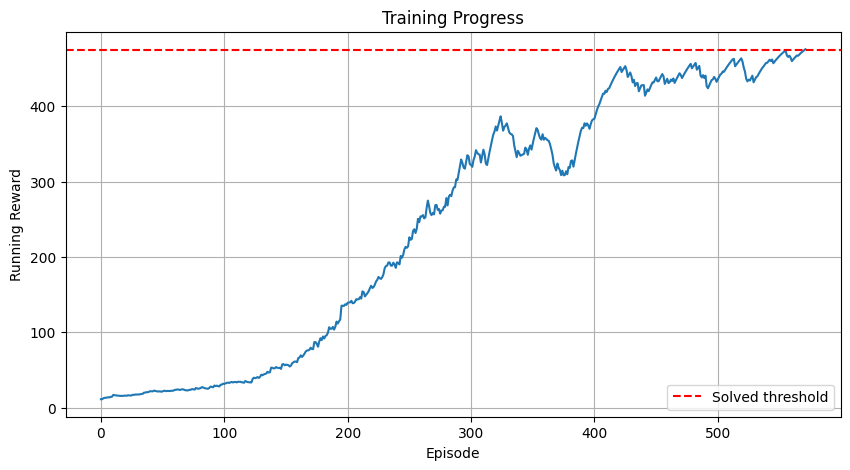

In [6]:
# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Running Reward')
plt.title('Training Progress')
plt.axhline(y=env.spec.reward_threshold, color='r', linestyle='--', label='Solved threshold')
plt.legend()
plt.grid(True)
plt.show()

### 4. Visualize the Value Function

The value function learns to predict expected future returns from each state. Let's visualize what it has learned about different states.

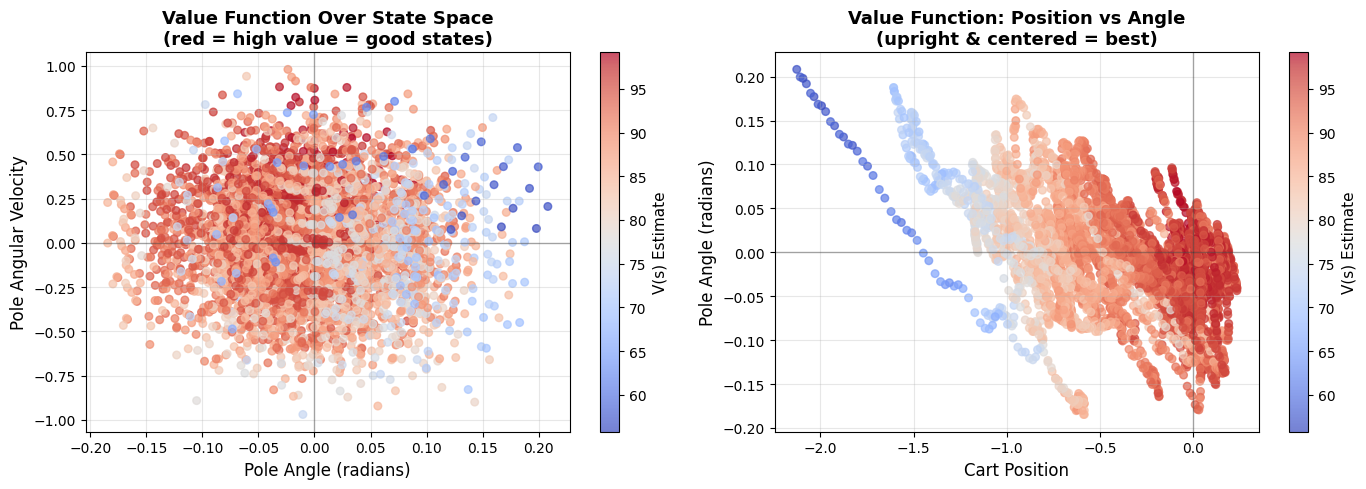

In [7]:
def visualize_value_function():
    policy.eval()
    vf.eval()
    
    # Run several episodes and collect states and value estimates
    num_episodes = 10
    all_states = []
    all_values = []
    
    for _ in range(num_episodes):
        state, _ = env.reset()
        
        # Collect trajectory
        for t in range(1000):
            state_tensor = torch.from_numpy(state).float().unsqueeze(0)
            
            with torch.no_grad():
                probs = policy(state_tensor)
                v = vf(state_tensor)
            
            all_states.append(state.copy())
            all_values.append(v.item())
            
            m = Categorical(probs)
            action = m.sample().item()
            
            state, reward, terminated, truncated, _ = env.step(action)
            
            if terminated or truncated:
                break
    
    all_states = np.array(all_states)
    all_values = np.array(all_values)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Pole angle vs angular velocity 
    pole_angle = all_states[:, 2]
    pole_velocity = all_states[:, 3]
    scatter1 = ax1.scatter(pole_angle, pole_velocity, c=all_values, 
                          cmap='coolwarm', alpha=0.7, s=30)
    ax1.set_xlabel('Pole Angle (radians)', fontsize=12)
    ax1.set_ylabel('Pole Angular Velocity', fontsize=12)
    ax1.set_title('Value Function Over State Space\n(red = high value = good states)', 
                  fontsize=13, fontweight='bold')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax1.grid(True, alpha=0.3)
    cbar1 = plt.colorbar(scatter1, ax=ax1)
    cbar1.set_label('V(s) Estimate', fontsize=11)
    
    # Right: Cart position vs pole angle
    cart_position = all_states[:, 0]
    scatter2 = ax2.scatter(cart_position, pole_angle, c=all_values, 
                          cmap='coolwarm', alpha=0.7, s=30)
    ax2.set_xlabel('Cart Position', fontsize=12)
    ax2.set_ylabel('Pole Angle (radians)', fontsize=12)
    ax2.set_title('Value Function: Position vs Angle\n(upright & centered = best)', 
                  fontsize=13, fontweight='bold')
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax2.grid(True, alpha=0.3)
    cbar2 = plt.colorbar(scatter2, ax=ax2)
    cbar2.set_label('V(s) Estimate', fontsize=11)
    
    plt.tight_layout()
    plt.show()

visualize_value_function()